In [29]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from uc_data import UCIrvineDataset
import torch.nn.functional as F
from poker_utils.model import plot_train_loss
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [95]:
train_dataset = UCIrvineDataset(test_size=0.6, train=True)
val_dataset = UCIrvineDataset(test_size=0.6, train=False)
trainloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [72]:
class TransformerBoardEncoder(nn.Module):
    def __init__(self, card_embeddings, card_dim=16, board_dim=16, num_heads=8, num_layers=2, freeze_emb=True):
        super().__init__()
        padding_row = torch.zeros((1, card_embeddings.size(1)))
        card_embeddings_padded = torch.cat([card_embeddings, padding_row], dim=0) 
        self.card_embedder = nn.Embedding.from_pretrained(
            card_embeddings_padded, padding_idx=52, freeze=freeze_emb)
        self.card_cls_tok = nn.Parameter(torch.randn(1, 1, card_dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=card_dim,
            nhead=num_heads,
            dropout=0.1,
            dim_feedforward=2*card_dim,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.output_proj = nn.Linear(card_dim, board_dim)

    def forward(self, board_ids):
        """
        card_ids: [B, L] where L <= 5, -1 for padding
        """
        B, L = board_ids.shape
        mask = (board_ids != -1)
        safe_ids = board_ids.masked_fill(~mask, 52)
        card_emb = self.card_embedder(safe_ids)
        card_cls_tok = self.card_cls_tok.expand(B, 1, -1)
        card_emb = torch.cat([card_cls_tok, card_emb], dim=1)
        
        pad_mask = torch.cat([torch.zeros(B, 1, dtype=torch.bool), ~mask], dim=1)
        x_transformed = self.transformer(card_emb, src_key_padding_mask=pad_mask)
        cls_out = x_transformed[:, 0, :]
        return self.output_proj(cls_out)
    
    
    

In [82]:
class HandStrengthPredictor(nn.Module):
    def __init__(self, card_embeddings, card_dim=16, board_dim=16, num_heads=8, num_layers=2, freeze_emb=True):
        super().__init__()
        self.board_encoder = TransformerBoardEncoder(
            card_embeddings,
            card_dim=card_dim, 
            board_dim=board_dim, 
            num_heads=num_heads, 
            num_layers=num_layers,
            freeze_emb=freeze_emb
            )
        
        self.model = nn.Sequential(
            nn.Linear(board_dim, 10),
            # nn.ReLU(),
            # nn.Dropout(p=0.1),
            # nn.Linear(64, 10)
            )
    
    def forward(self, hand_ids, board_ids):
        hand_board_ids = torch.cat([hand_ids, board_ids],dim=1)
        hand_board_encoded = self.board_encoder(hand_board_ids)
        return self.model(hand_board_encoded)

In [94]:
def train_model(model, trainloader, optimizer, scheduler=None, device=None, valloader=None, epochs=50,leftoff=0):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    class_weights = torch.load("model_weights/class_weights.pt", weights_only=True)
    for epoch in range(epochs):
        tot_train_loss = 0
        correct_train = 0
        total_train = 0

        model.train()
        for batch in trainloader:
            optimizer.zero_grad()
            hand, board, strength = [x.to(device) for x in batch] if device is not None else batch
            strength_pred = model(hand, board)
            batch_loss = F.cross_entropy(strength_pred, strength, weight=class_weights)
            batch_loss.backward()
            optimizer.step()
            if scheduler is not None:
                scheduler.step()
            tot_train_loss += batch_loss.item()
            preds = strength_pred.argmax(dim=1)
            correct_train += (preds == strength).sum().item()
            total_train += strength.size(0)

        avg_train_loss = tot_train_loss / len(trainloader)
        train_acc = correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_acc)

        if valloader is not None:
            model.eval()
            tot_val_loss = 0
            correct_val = 0
            total_val = 0

            with torch.no_grad():
                for batch in valloader:
                    hand, board, strength = [x.to(device) for x in batch] if device is not None else batch
                    strength_pred = model(hand, board)
                    batch_loss = F.cross_entropy(strength_pred, strength, weight=class_weights)
                    tot_val_loss += batch_loss.item()
                    preds = strength_pred.argmax(dim=1)
                    correct_val += (preds == strength).sum().item()
                    total_val += strength.size(0)

            avg_val_loss = tot_val_loss / len(valloader)
            val_acc = correct_val / total_val
            val_losses.append(avg_val_loss)
            val_accuracies.append(val_acc)

        if valloader is not None:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                  f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")
        else:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}")
        if (epoch + 1) % 5 == 0:
            torch.save(model.state_dict(), f"model_weights/hand_strength_predictor{leftoff+epoch+1}.pth")

    if valloader is not None:
        return {"train_loss":train_losses, 
                "val_loss":val_losses, 
                "train_accuracy":train_accuracies, 
                "val_accuracy":val_accuracies}
    else:
        return {'train_loss':train_losses, "train_accuracy":train_accuracies}


In [88]:
card_embeddings = torch.load('embeddings/card_embeddings.pt', weights_only=True)

In [89]:
# state_dict = torch.load("model_weights/hand_strength_predictor.pth", weights_only=True)
model = HandStrengthPredictor(
        card_embeddings=card_embeddings,
        card_dim=16,
        board_dim=16,
        num_heads=8, 
        num_layers=4, 
        freeze_emb=True
        ).to(device)

In [90]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [ ]:
res = train_model(
        model=model,
        trainloader=trainloader,
        valloader=valloader,
        optimizer=optimizer,
        scheduler=None,
        device=None,
        epochs=100,
        leftoff=200
        )

c:\Users\campb\miniconda3\envs\poker_env\lib\site-packages\torch\nn\modules\transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\NestedTensorImpl.cpp:180.)
  output = torch._nested_tensor_from_mask(


Epoch 1/100, Train Loss: 1.0462, Train Acc: 0.5253, Val Loss: 0.8419, Val Acc: 0.6239
Epoch 2/100, Train Loss: 1.0016, Train Acc: 0.5383, Val Loss: 0.8469, Val Acc: 0.5877
Epoch 3/100, Train Loss: 0.9770, Train Acc: 0.5450, Val Loss: 0.7513, Val Acc: 0.6149
Epoch 4/100, Train Loss: 0.9674, Train Acc: 0.5502, Val Loss: 0.7476, Val Acc: 0.6551
Epoch 5/100, Train Loss: 0.9461, Train Acc: 0.5603, Val Loss: 0.6971, Val Acc: 0.6723
Epoch 6/100, Train Loss: 0.9284, Train Acc: 0.5629, Val Loss: 0.7239, Val Acc: 0.6648
Epoch 7/100, Train Loss: 0.9224, Train Acc: 0.5631, Val Loss: 0.7236, Val Acc: 0.6538
Epoch 8/100, Train Loss: 0.9155, Train Acc: 0.5697, Val Loss: 0.7292, Val Acc: 0.6215
Epoch 9/100, Train Loss: 0.9161, Train Acc: 0.5663, Val Loss: 0.7176, Val Acc: 0.6173
Epoch 10/100, Train Loss: 0.8962, Train Acc: 0.5752, Val Loss: 0.6948, Val Acc: 0.6321
Epoch 11/100, Train Loss: 0.8861, Train Acc: 0.5749, Val Loss: 0.7208, Val Acc: 0.6533
Epoch 12/100, Train Loss: 0.8675, Train Acc: 0.5826,

In [99]:
res.keys()

dict_keys(['train_loss', 'val_loss', 'train_accuracy', 'val_accuracy'])

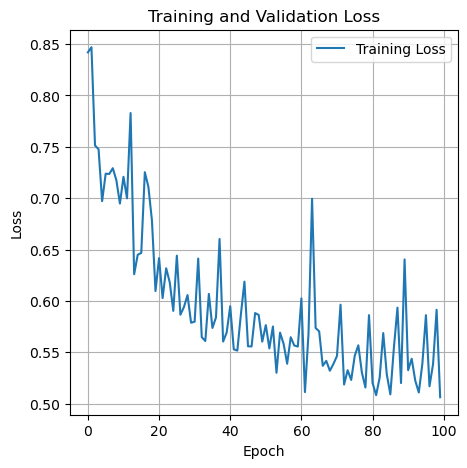

In [102]:
plot_train_loss(res['val_loss'])

In [56]:
def get_classification_report(model, dataloader, device=None):
    all_preds = []
    all_labels = []
    all_indices = []
    class_names = [
        "nothing", "one_pair", "two_pair", "three_of_a_kind", "straight",
        "flush", "full_house", "four_of_a_kind", "straight_flush", "royal_flush"
        ]
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            hand_id, suit1_id, suit2_id, board, labels = [x.to(device) for x in batch] if device is not None else batch
            outputs = model(hand_id, suit1_id, suit2_id, board)
            preds = outputs.argmax(dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
            all_indices.extend(range(i * dataloader.batch_size, (i + 1) * dataloader.batch_size))
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    report = classification_report(all_labels, all_preds, target_names=class_names)
    cm = confusion_matrix(all_labels, all_preds)
    return report, cm


In [57]:
report, cm = get_classification_report(model, trainloader)

c:\Users\campb\miniconda3\envs\poker_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\campb\miniconda3\envs\poker_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\campb\miniconda3\envs\poker_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

In [54]:
class_names = [
        "nothing", "one_pair", "two_pair", "three_of_a_kind", "straight",
        "flush", "full_house", "four_of_a_kind", "straight_flush", "royal_flush"
        ]

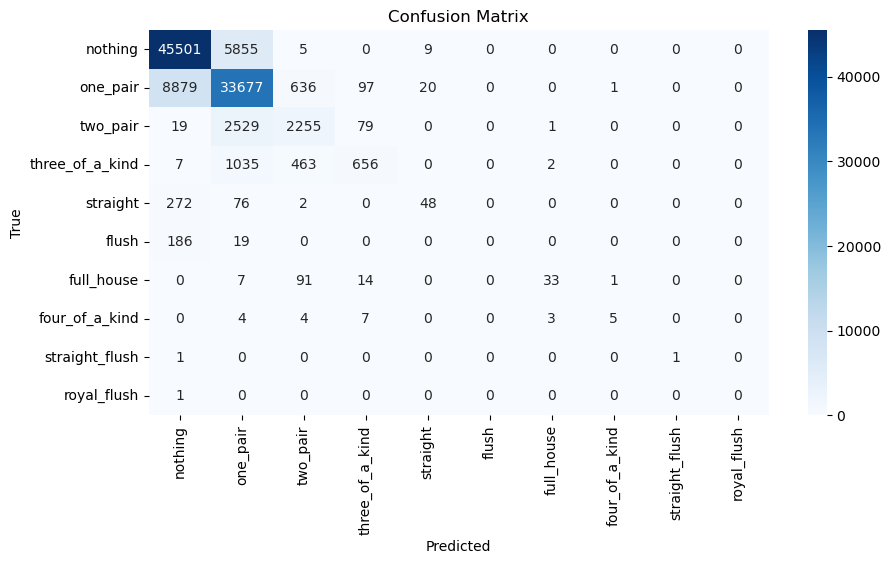

In [63]:
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
